# Firing rate at different positions

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats

from dataloader import BaseDataset
from utils.plot_utils import label_diff
from param import *

In [2]:

spikes_at_position_all = []
mouse_type_list = []
ratio_all = []
for data_dir in ParamDir().data_list:

    data_name = str(data_dir).split('/')[-1]
    mouse_type = "KO" if "KO" in data_name else "WT"
    dataset = BaseDataset(data_dir, ParamData().mobility, ParamData().shuffle, ParamData().random_state)
    position = dataset._discretize_coords()

    # ratio of each position
    classes, count = np.unique(position, return_counts=True)
    ratio = count/np.sum(count) 
    ratio_all.append([ratio, mouse_type])      

    # mean firing rate at each position
    # -- group spikes by position
    df = pd.DataFrame(np.hstack([position.reshape(-1,1), dataset.spikes]))
    df.columns = ["position"]+[i for i in range(dataset.spikes.shape[1])]
    df_group = df.groupby("position").sum()
    # -- cal firing rate by position
    for row_i , row in df_group.iterrows():
        df_group.iloc[row_i-1]= row/(count[row_i-1]/3)
    spikes_at_position_all.extend(df_group.T.values)
    mouse_type_list.extend([f"{mouse_type}"]*len(df_group.T.values))



In [3]:
df_spikes_on_position_all = pd.DataFrame(spikes_at_position_all, columns=[str(i+1) for i in range(len(count))])
df_spikes_on_position_all["mouse type"] = mouse_type_list
mean_spikes_at_position = df_spikes_on_position_all.groupby("mouse type").mean().values
std_spikes_at_position = df_spikes_on_position_all.groupby("mouse type").std().values

df_ratio_all = pd.DataFrame(
    ratio_all,
    columns=["ratio of position", "mouse type"]
)

mean_ratio = df_ratio_all.groupby("mouse type").mean().values
std_ratio = [
    df_ratio_all[df_ratio_all["mouse type"]=="KO"]["ratio of position"].values.std(),
    df_ratio_all[df_ratio_all["mouse type"]=="WT"]["ratio of position"].values.std() ]
ind = [str(i+1) for i in range(len(std_ratio[0]))]

In [8]:
df_spikes_on_position_all[df_spikes_on_position_all["mouse type"]=="KO"][["1", "2"]].values

array([[0.01074306, 0.01923077],
       [0.01074306, 0.00480769],
       [0.0080573 , 0.03365385],
       [0.00268577, 0.03846154],
       [0.02148612, 0.00961538],
       [0.00537153, 0.00961538],
       [0.01611459, 0.01923077],
       [0.01074306, 0.00961538],
       [0.02417189, 0.01442308],
       [0.01611459, 0.0625    ],
       [0.02148612, 0.03846154],
       [0.04028648, 0.03846154],
       [0.03760072, 0.01442308],
       [0.05640107, 0.06730769],
       [0.04834378, 0.00961538],
       [0.0080573 , 0.02403846],
       [0.03491495, 0.04326923],
       [0.05102954, 0.04326923],
       [0.04028648, 0.03846154],
       [0.05371531, 0.04326923],
       [0.03491495, 0.02884615],
       [0.01074306, 0.05769231],
       [0.05102954, 0.04326923],
       [0.00268577, 0.02403846],
       [0.0080573 , 0.01442308],
       [0.01074306, 0.05769231],
       [0.06177261, 0.07211538],
       [0.04565801, 0.03365385],
       [0.03760072, 0.03365385],
       [0.04028648, 0.08173077],
       [0.

In [14]:
tmp = df_spikes_on_position_all[df_spikes_on_position_all["mouse type"]=="WT"][["2", "3"]].values
stats.ttest_ind(tmp[:,0], tmp[:,1])

Ttest_indResult(statistic=0.38308358827154615, pvalue=0.7017392048560458)

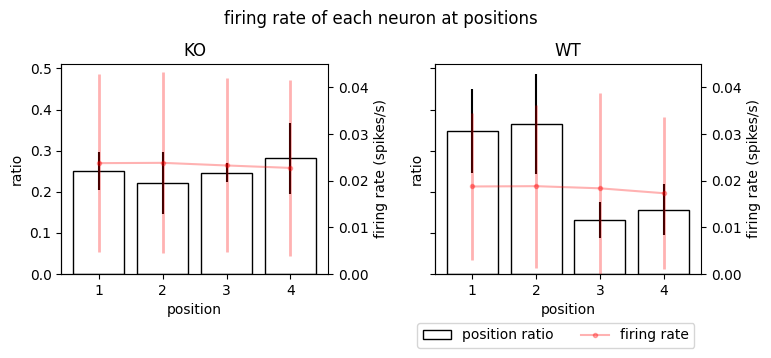

In [4]:
fig, axes = plt.subplots(figsize=(8,3), ncols=2, sharey=True)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.8,
                    wspace=0.4,
                    hspace=0.4)
sns.despine()

for plot_i in range(2):
    mouse_type = "KO" if plot_i == 0 else "WT"
    lin1 = axes[plot_i].bar(ind, mean_ratio[plot_i][0], 
                     yerr=std_ratio[plot_i], 
                     facecolor="white", 
                     edgecolor="black",
                     label="position ratio")  
    axes[plot_i].set_title(mouse_type)
    axes[plot_i].set_xlabel("position")
    axes[plot_i].set_ylabel("ratio")

    ax2 = axes[plot_i].twinx()

    lin2 = ax2.errorbar(
        ind, mean_spikes_at_position[plot_i], 
        color="r", 
        alpha=.3, 
        marker=".", 
        yerr=std_spikes_at_position[plot_i],
        elinewidth=2,
        label="firing rate")
    ax2.set_ylim(0 , 0.045)
    ax2.set_ylabel("firing rate (spikes/s)")

plt.suptitle("firing rate of each neuron at positions")
plt.legend(
    [lin1[0], lin2[0]], [l.get_label() for l in [lin1, lin2]], 
    ncol=2, 
    bbox_to_anchor=(1,-.2))